In [1]:
import sys
sys.path.append('/content/SN/Scripts')

!apt-get install git
!git clone https://github.com/afyanyan/SN.git
import numpy as np
#from SNutils import SN
from SNkernels import KernelUtils as KU
from SNkernels import QuarticKernel,ExpCompositeKernel, ReducedQuarticKernel  # Import custom kernels
from sklearn.gaussian_process.kernels import WhiteKernel
import pandas as pd
from random import randint



Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git is already the newest version (1:2.34.1-1ubuntu1.15).
0 upgraded, 0 newly installed, 0 to remove and 2 not upgraded.
Cloning into 'SN'...
remote: Enumerating objects: 816, done.
remote: Counting objects: 100% (385/385), done.
remote: Compressing objects: 100% (315/315), done.
remote: Total 816 (delta 56), reused 285 (delta 16), pack-reused 431 (from 1)
Receiving objects: 100% (816/816), 3.85 MiB | 4.16 MiB/s, done.
Resolving deltas: 100% (281/281), done.


In [2]:
import matplotlib.pyplot as plt

class SN:
    def __init__(self,
                 lc,
                 bkg
                 ):
        self.lc = lc
        self.bkg = bkg

    def read_data(self):
        df_bkg = pd.read_csv(self.bkg)
        df_lc = pd.read_csv(self.lc)

        t = df_lc['MJD']
        self.epoch = np.min(t)
        self.time = np.array(t - self.epoch)
        self.mag = np.array(df_lc['mag'])
        self.ave_BKG = np.mean(df_bkg['mag'])
        #self.lnd_t = np.array(df_bkg[0])
        return self.time, self.mag

    # Function to plot data
    def plot_data(self):
        plt.plot(self.time, self.mag,'.', color = 'red', label = 'Data Points')
        plt.xlabel('t [days from the discovery]')
        plt.ylabel('SAP Flux Normalized (e-/s)')
        plt.gca().invert_yaxis()
        plt.legend()
        plt.grid()
        plt.savefig(self.lc.split('.')[0]+'.png')
        return

    # Function to estimate shock break out time by finding the minimum gradient
    def shock_breakout(self, Xp, yp, ystd):
       #start at peak of data and move left
       normalized_mag = yp - float(self.ave_BKG) #magnitude of the fit minus the background
       peak_time = Xp[np.argmin(yp)]
       df_bkg = pd.read_csv(self.bkg)
       lnd = float(df_bkg['MJD'].iloc[0] if isinstance(df_bkg['MJD'], pd.Series) else df_bkg['MJD'])
       filter = (Xp <= peak_time) & (Xp+self.epoch >= lnd)
       filtered_normalized_mag = normalized_mag[filter]
       filtered_ystd = ystd[filter]
       filtered_Xp = Xp[filter]
       self.t_sbo = filtered_Xp[(np.argmin(abs(filtered_normalized_mag)))] #finds where normalized_mag is closest to 0
       self.t_sbo_l = filtered_Xp[np.argmin(abs(filtered_normalized_mag - filtered_ystd))]
       self.t_sbo_r = filtered_Xp[np.argmin(abs(filtered_normalized_mag + filtered_ystd))]
       print(self.t_sbo+self.epoch)
       if self.t_sbo_l <= self.t_sbo <= self.t_sbo_r:
        print ("The predicted shock break out time is at", self. t_sbo+self.epoch, " and is between", self.t_sbo_l+self.epoch," and ",self.t_sbo_r+self.epoch," in MJD")
       else:
        print('Unable to calculate shock breakout')
       return

     # Function to plot the fit
    def plot_fit(self, Xp, yp, ystd):
        plt.figure(figsize=(8,5))
        plt.plot(self.time+self.epoch, self.mag, 'r.', label='Observed data')
        plt.axhline(self.ave_BKG, color='black', linestyle='-',label="BKG")
        plt.plot(Xp+self.epoch, yp, color='blue', alpha=0.25)
        plt.fill_between(Xp+self.epoch, yp-ystd, yp+ystd, alpha=0.1,color='b')
        plt.xlabel('Days')
        plt.ylabel('mag')
        plt.ylim([np.min(self.mag)-1,np.max(self.ave_BKG)+1])
        plt.gca().invert_yaxis()
        plt.plot(self.t_sbo+self.epoch, self.ave_BKG, marker="*", markersize=15, label="t_SBO",     color='y')
        df_bkg = pd.read_csv(self.bkg)
        plt.scatter(df_bkg['MJD'], df_bkg['mag'], color='black', label='Last Null Detection')
        plt.grid()
        plt.legend()
        ax = plt.gca()
        ax.annotate(self.t_sbo+self.epoch,
            xy=(self.t_sbo+self.epoch, self.ave_BKG),
            xytext=(self.t_sbo+self.epoch + 5, self.ave_BKG + 0.5),
            arrowprops=dict(facecolor='black', shrink=0.05),
            horizontalalignment='left', verticalalignment='top',
            fontsize=12)
        plot_title = "Shock break out time from %.2f to %.2f MJD" % (self.t_sbo_l+self.epoch, self.t_sbo_r+self.epoch)
        plt.title(plot_title)
        plt.savefig(self.lc.split('.')[0]+'-fit.png')

/usr/local/lib/python3.12/dist-packages/sklearn/gaussian_process/_gpr.py:478: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn(


Kernel type: Sum
Optimized hyperparameters:
  k1__alpha : 0.131089  (bounds: [[1.e-06 1.e+01]])
  k1__beta  : 0.00785775  (bounds: [[1.e-06 1.e+01]])
  k1__delta : 0.00868952  (bounds: [[1.e-06 1.e+01]])
  k1__gamma : 0.342847  (bounds: [[1.e-06 1.e+01]])
  k2__noise_level: 0.184657  (bounds: [[1.e-06 1.e+01]])
60304.830111
The predicted shock break out time is at 60304.830111  and is between 60304.830111  and  60304.830111  in MJD


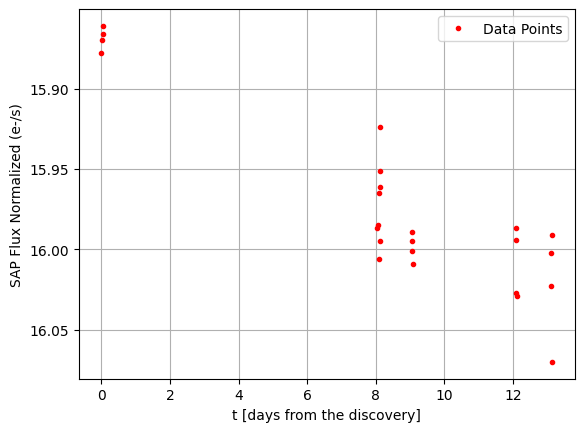

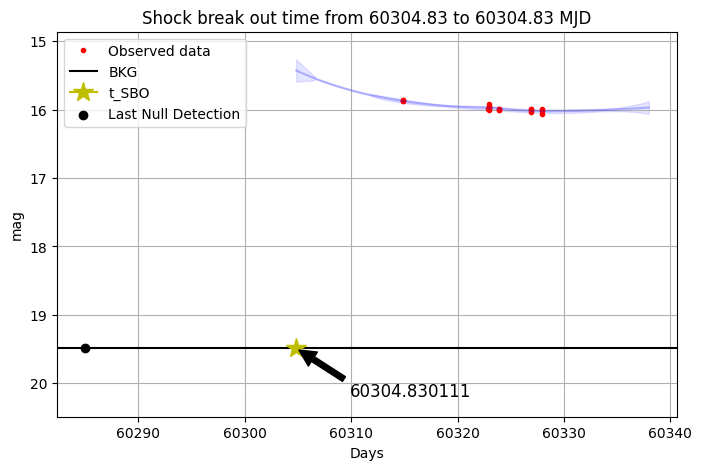

In [3]:
import os
import numpy as np # Ensure numpy is imported if not already in the main function's scope
import pandas as pd # Import pandas to resolve NameError

def main():
    # Load supernova data

    # Create the df_bkg DataFrame with expected columns
    df_bkg = pd.DataFrame({
    'MJD': [float('60284.99314815')],
    'mag': [float('19.49')],
    'magerr': [float('0.1')] # Ensure 'magerr' is also present as expected by SNutils.py's parsing
    })

    # Save the df_bkg DataFrame to a temporary CSV file
    temp_bkg_file = 'temp_background.csv'
    # Save with header and default comma separator, so pd.read_csv can infer column names
    df_bkg.to_csv(temp_bkg_file, index=False, header=True)

    # Pass the path to the temporary CSV file to the SN constructor for background data
    supernova = SN(bkg=temp_bkg_file, lc='/content/SN/O4_SN/o4_supernovae/SN_2023zcu/sn_2023zcu_atlas_c.dat')

    # Read and plot data
    time, mag = supernova.read_data()
    supernova.plot_data()

    # Define supernova kernel
    kernel = (
            #ReducedQuarticKernel() *
            ExpCompositeKernel()
            + WhiteKernel(noise_level=1e-3, noise_level_bounds=(1e-6, 1e1))
        )

    # Fit Gaussian Process Regression model
    Xp, yp, ystd = KU.fit(time, mag, kernel)

    # Estimate shock break out time
    supernova.shock_breakout(Xp, yp, ystd)
    # Plot the results
    supernova.plot_fit(Xp, yp, ystd)

    # Clean up the temporary file
    os.remove(temp_bkg_file)
#N_loop = int(input("Enter number of iterations: "))
#i=0
#while i <= N_loop:
if __name__ == "__main__":
    main()